In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import cv2
import os
import pathlib

In [ ]:
pre_trained_model = InceptionV3(input_shape=(299, 299, 3), weights='imagenet')

96116736/96112376 [==============================] - 1s 0us/step


In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [ ]:
def LoadImage(path):
  print(bcolors.OKGREEN + "[INFO]" + bcolors.ENDC + bcolors.BOLD + " loading and pre-processing image..." + bcolors.ENDC)
  image = load_img(path, target_size=(299, 299))
  image = img_to_array(image)
  image = np.expand_dims(image, axis=0)
  image = preprocess_input(image)
  return image

In [ ]:
def Predict(model, image):
  print(bcolors.OKGREEN + "[INFO]" + bcolors.ENDC + bcolors.BOLD + " classifying image with '{}'...".format("Inception") + bcolors.ENDC)
  preds = model.predict(image)
  P = imagenet_utils.decode_predictions(preds)
  for (i, (imagenetID, label, prob)) in enumerate(P[0]):
    print("{}. {}: ".format(i + 1, label) + bcolors.BOLD + "{:.2f}%".format(prob * 100) + bcolors.ENDC)


In [ ]:
Predict(pre_trained_model, LoadImage("elephant.jpg"))
Predict(pre_trained_model, LoadImage("jelly1.jpg"))
Predict(pre_trained_model, LoadImage("jelly2.jpg"))
Predict(pre_trained_model, LoadImage("meerkat.jpg"))

[INFO] loading and pre-processing image...
[INFO] classifying image with 'Inception'...
1. African_elephant: 77.13%
2. tusker: 17.98%
3. Indian_elephant: 1.27%
4. miniskirt: 0.13%
5. notebook: 0.04%
[INFO] loading and pre-processing image...
[INFO] classifying image with 'Inception'...
1. jellyfish: 89.21%
2. sea_anemone: 0.17%
3. cicada: 0.12%
4. rapeseed: 0.08%
5. chambered_nautilus: 0.08%
[INFO] loading and pre-processing image...
[INFO] classifying image with 'Inception'...
1. jellyfish: 96.32%
2. spotlight: 0.03%
3. oscilloscope: 0.03%
4. nematode: 0.03%
5. stage: 0.02%
[INFO] loading and pre-processing image...
[INFO] classifying image with 'Inception'...
1. meerkat: 88.61%
2. mongoose: 7.97%
3. Madagascar_cat: 0.15%
4. indri: 0.03%
5. otter: 0.02%


# Transfer Learning


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [331, 331]

batch_size = 128

gcs_pattern = 'gs://flowers-public/tfrecords-jpeg-331x331/*.tfrec'
validation_split = 0.19
filenames = tf.io.gfile.glob(gcs_pattern)
split = len(filenames) - int(len(filenames) * validation_split)
train_fns = filenames[:split]
validation_fns = filenames[split:]
        
def parse_tfrecord(example):
  features = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "class": tf.io.FixedLenFeature([], tf.int64),
    "one_hot_class": tf.io.VarLenFeature(tf.float32),
  }
  example = tf.io.parse_single_example(example, features)
  decoded = tf.image.decode_jpeg(example['image'], channels=3)
  normalized = tf.cast(decoded, tf.float32) / 255.0 
  image_tensor = tf.reshape(normalized, [*IMAGE_SIZE, 3])
  one_hot_class = tf.reshape(tf.sparse.to_dense(example['one_hot_class']), [5])
  return image_tensor, one_hot_class

def load_dataset(filenames):
  records = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  return records.map(parse_tfrecord, num_parallel_calls=AUTO)

def get_validation_dataset():
  dataset = load_dataset(validation_fns)
  def data_augment(image, one_hot_class):
    modified = tf.image.resize_with_pad(image, 299, 299)
    return modified, one_hot_class
  augmented = dataset.map(data_augment, num_parallel_calls=AUTO)
  return augmented.batch(batch_size).prefetch(AUTO)

def get_training_dataset():
  dataset = load_dataset(train_fns)
  
  def data_augment(image, one_hot_class):
    modified = tf.image.random_flip_left_right(image)
    modified = tf.image.random_saturation(modified, 0, 2)
    modified = tf.image.resize_with_pad(modified, 299, 299)
    return modified, one_hot_class
  augmented = dataset.map(data_augment, num_parallel_calls=AUTO)

  return augmented.repeat().shuffle(2048).batch(batch_size).prefetch(AUTO) 

training_dataset = get_training_dataset()
validation_dataset = get_validation_dataset()

In [ ]:
validation_dataset

<PrefetchDataset shapes: ((None, 299, 299, 3), (None, 5)), types: (tf.float32, tf.float32)>

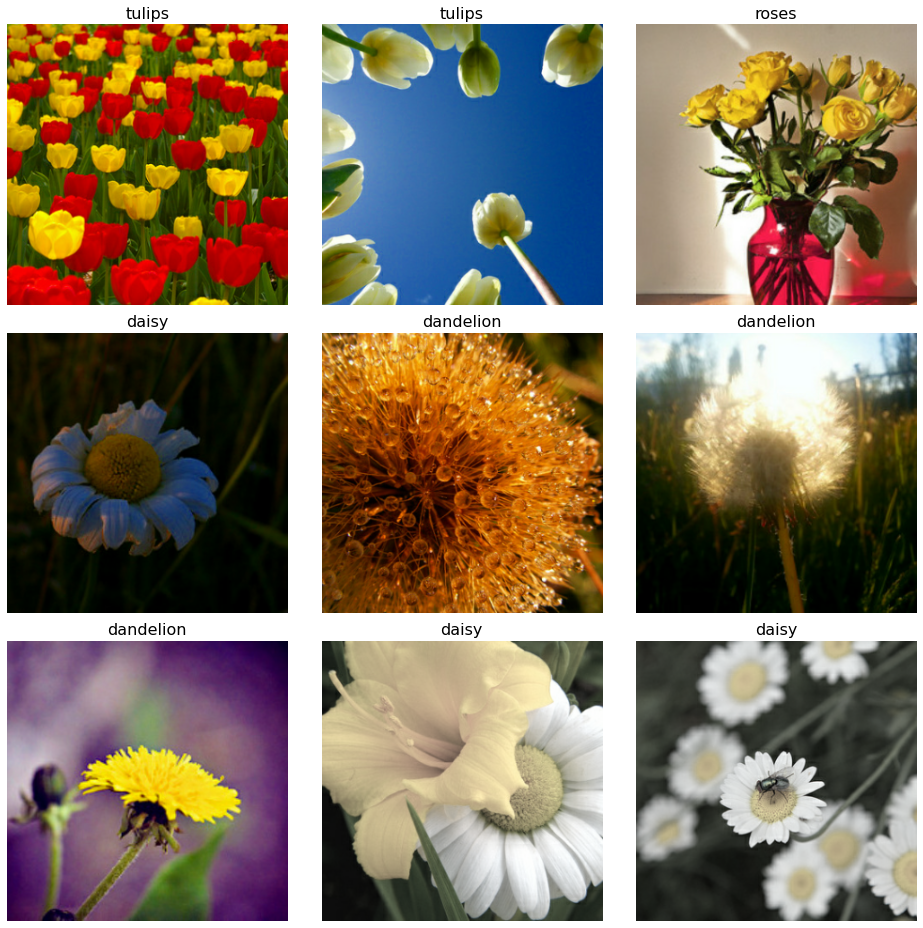

In [ ]:
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

def display_one_flower(image, title, subplot, color):
  plt.subplot(subplot)
  plt.axis('off')
  plt.imshow(image)
  plt.title(title, fontsize=16, color=color)
  
def display_nine_flowers(images, titles, title_colors=None):
  subplot = 331
  plt.figure(figsize=(13,13))
  for i in range(9):
    color = 'black' if title_colors is None else title_colors[i]
    display_one_flower(images[i], titles[i], 331+i, color)
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

iter = training_dataset.unbatch().batch(9).as_numpy_iterator()
images, classes = iter.next()
class_idxs = np.argmax(classes, axis=-1)
labels = [CLASSES[idx] for idx in class_idxs]
display_nine_flowers(images, labels)

In [ ]:
import re
def count_data_items(filenames):
  n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
  return np.sum(n)

n_train = count_data_items(train_fns)
n_valid = count_data_items(validation_fns)
train_steps = count_data_items(train_fns) // batch_size
print("TRAINING IMAGES: ", n_train, ", STEPS PER EPOCH: ", train_steps)
print("VALIDATION IMAGES: ", n_valid)

TRAINING IMAGES:  2990 , STEPS PER EPOCH:  23
VALIDATION IMAGES:  680


In [ ]:
def create_model():
  inception = InceptionV3(input_shape=(299, 299, 3), weights='imagenet', include_top=False)
  inception.trainable = False
  model = tf.keras.Sequential([
    inception,
    GlobalAveragePooling2D(name='global_average_pool'),
    Dropout(0.3, name='dropout1'),
    Dense(1024, activation='relu', name='FC1'),
    Dropout(0.3, name='dropout2'),
    Dense(512, activation='relu', name='FC2'),
    Dropout(0.3, name='dropout3'),
    Dense(5, activation='softmax', name='output')
  ], name='myInception')
  model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
  )
  return model

model = create_model()
model.summary()

Model: "myInception"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pool (GlobalA (None, 2048)              0         
_________________________________________________________________
dropout1 (Dropout)           (None, 2048)              0         
_________________________________________________________________
FC1 (Dense)                  (None, 1024)              2098176   
_________________________________________________________________
dropout2 (Dropout)           (None, 1024)              0         
_________________________________________________________________
FC2 (Dense)                  (None, 512)               524800    
_________________________________________________________________
dropout3 (Dropout)           (None, 512)               

Learning rate per epoch:


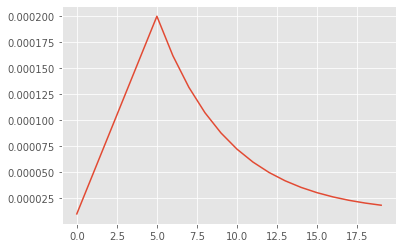

In [ ]:
EPOCHS = 20
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005 * 4
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)

lr = np.arange(EPOCHS)
y = [lrfn(x) for x in lr]
plt.plot(lr, y)

In [ ]:
history = model.fit(training_dataset, validation_data=validation_dataset, steps_per_epoch=train_steps, epochs=EPOCHS, callbacks=[lr_callback])

Epoch 1/20

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
23/23 [==============================] - 66s 879ms/step - loss: 1.7382 - accuracy: 0.2112 - val_loss: 1.4430 - val_accuracy: 0.4735
Epoch 2/20

Epoch 00002: LearningRateScheduler reducing learning rate to 4.8e-05.
23/23 [==============================] - 16s 685ms/step - loss: 1.4175 - accuracy: 0.4055 - val_loss: 0.8709 - val_accuracy: 0.7721
Epoch 3/20

Epoch 00003: LearningRateScheduler reducing learning rate to 8.6e-05.
23/23 [==============================] - 16s 683ms/step - loss: 0.9462 - accuracy: 0.6471 - val_loss: 0.5153 - val_accuracy: 0.8456
Epoch 4/20

Epoch 00004: LearningRateScheduler reducing learning rate to 0.000124.
23/23 [==============================] - 15s 659ms/step - loss: 0.6636 - accuracy: 0.7551 - val_loss: 0.3865 - val_accuracy: 0.8691
Epoch 5/20

Epoch 00005: LearningRateScheduler reducing learning rate to 0.000162.
23/23 [==============================] - 15s 650ms/step - loss

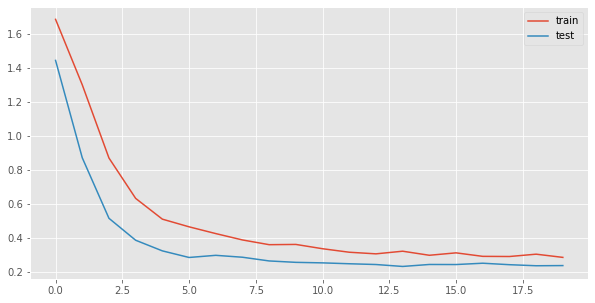

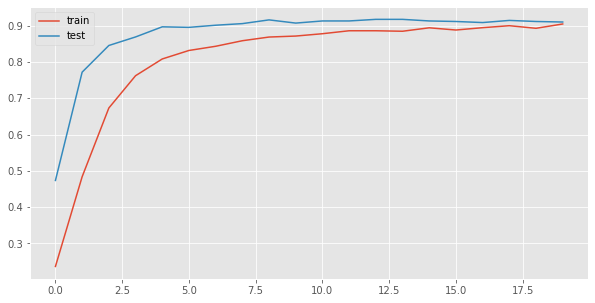

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'])
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train', 'test'])
plt.show()

In [ ]:
def PredictFlowers(model, image):
  print(bcolors.OKGREEN + "[INFO]" + bcolors.ENDC + bcolors.BOLD + " classifying image with '{}'...".format("Inception") + bcolors.ENDC)
  preds = model.predict(image)
  id = np.flip(np.argsort(preds)[0][-3:])
  probs = np.flip(np.sort(preds)[0][-3:])
  i = 0
  for label, prob in zip(id, probs):
    print("{}. {}: ".format(i + 1, CLASSES[label]) + bcolors.BOLD + "{:.2f}%".format(prob * 100) + bcolors.ENDC)
    i += 1


In [ ]:
## عکس باغچه
image = LoadImage("IMG_8058.JPG")
PredictFlowers(model, image)

[INFO] loading and pre-processing image...
[INFO] classifying image with 'Inception'...
1. roses: 85.91%
2. tulips: 14.07%
3. sunflowers: 0.01%


In [ ]:
## باغ ارم شیراز
image = LoadImage("garden.jpg")
PredictFlowers(model, image)

[INFO] loading and pre-processing image...
[INFO] classifying image with 'Inception'...
1. roses: 76.22%
2. tulips: 23.70%
3. sunflowers: 0.08%


In [ ]:
## پارک آب و آتش
image = LoadImage("IMG_8723.JPG")
PredictFlowers(model, image)

[INFO] loading and pre-processing image...
[INFO] classifying image with 'Inception'...
1. tulips: 99.80%
2. sunflowers: 0.11%
3. dandelion: 0.04%


In [ ]:
model.save_weights('flowers.h5')